In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%env CUDA_VISIBLE_DEVICES=2

env: CUDA_VISIBLE_DEVICES=2


In [3]:
import argparse

import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader, Dataset, dataloader

import torch.nn.init as init

# from read_dataset import data_from_name
from multires_loader import MultiresDataset
from model import *
from tools import *
from train_multires import *

import os
import wandb

In [4]:
parser = argparse.ArgumentParser(description='PyTorch Example')
#
parser.add_argument('--model', type=str, default='koopmanAE', metavar='N', help='model')
#
parser.add_argument('--alpha', type=int, default='1',  help='model width')
#
parser.add_argument('--dataset', type=str, default='flow_noisy', metavar='N', help='dataset')
#
parser.add_argument('--theta', type=float, default=2.4,  metavar='N', help='angular displacement')
#
parser.add_argument('--noise', type=float, default=0.0,  metavar='N', help='noise level')
#
parser.add_argument('--lr', type=float, default=1e-2, metavar='N', help='learning rate (default: 0.01)')
#
parser.add_argument('--wd', type=float, default=0.0, metavar='N', help='weight_decay (default: 1e-5)')
#
parser.add_argument('--epochs', type=int, default=600, metavar='N', help='number of epochs to train (default: 10)')
#
parser.add_argument('--batch', type=int, default=64, metavar='N', help='batch size (default: 10000)')
#
parser.add_argument('--batch_test', type=int, default=200, metavar='N', help='batch size  for test set (default: 10000)')
#
parser.add_argument('--plotting', type=bool, default=True, metavar='N', help='number of epochs to train (default: 10)')
#
parser.add_argument('--folder', type=str, default='test',  help='specify directory to print results to')
#
parser.add_argument('--lamb', type=float, default='1',  help='balance between reconstruction and prediction loss')
#
parser.add_argument('--nu', type=float, default='1e-1',  help='tune backward loss')
#
parser.add_argument('--eta', type=float, default='1e-2',  help='tune consistent loss')
#
parser.add_argument('--steps', type=int, default='8',  help='steps for learning forward dynamics')
#
parser.add_argument('--steps_back', type=int, default='8',  help='steps for learning backwards dynamics')
#
parser.add_argument('--bottleneck', type=int, default='6',  help='size of bottleneck layer')
#
parser.add_argument('--lr_update', type=int, nargs='+', default=[30, 200, 400, 500], help='decrease learning rate at these epochs')
#
parser.add_argument('--lr_decay', type=float, default='0.2',  help='PCL penalty lambda hyperparameter')
#
parser.add_argument('--backward', type=int, default=0, help='train with backward dynamics')
#
parser.add_argument('--init_scale', type=float, default=0.99, help='init scaling')
#
parser.add_argument('--gradclip', type=float, default=0.05, help='gradient clipping')
#
parser.add_argument('--pred_steps', type=int, default='1000',  help='prediction steps')
#
parser.add_argument('--seed', type=int, default='1',  help='seed value')
#

'''
for multires data
'''
parser.add_argument('--data', type=str, default='')
parser.add_argument('--seq_in_len', type=int, default=1440)
parser.add_argument('--seq_out_len', type=int, default=480)
parser.add_argument('--seq_diff', type=int, default=48)
parser.add_argument('--test_seq_diff', type=int, default=48, help='only used for test set to reduce num of seqs for saving')
parser.add_argument('--target_res', type=str, default='30min', help='30min/6-hour/day/all')
parser.add_argument('--resolution_type', type=str, default='agg')
parser.add_argument('--single_res_input_output', action='store_true', help='true if used for verification on existing exps')

# load saved model
parser.add_argument('--load_saved_model', default='')

_StoreAction(option_strings=['--load_saved_model'], dest='load_saved_model', nargs=None, const=None, default='', type=None, choices=None, help=None, metavar=None)

In [5]:
import shlex


params = shlex.split('--data ../../data/nyc_taxi/manhattan \
--seq_in_len 1440 \
--seq_out_len 480 \
--seq_diff 48 \
--single_res_input_output \
--alpha 8 --lr 1e-3 --epochs 1 --batch 64 --batch_test 64 --folder test/multires --steps 480 --steps_back 480 --bottleneck 128 --backward 1 --pred_steps 480 --seed 42 \
--load_saved_model test/multires/nyctaxi/epoch-6.pkl')
args = parser.parse_args(params)

In [6]:
args

Namespace(alpha=8, backward=1, batch=64, batch_test=64, bottleneck=128, data='../../data/nyc_taxi/manhattan', dataset='flow_noisy', epochs=1, eta=0.01, folder='test/multires', gradclip=0.05, init_scale=0.99, lamb=1.0, load_saved_model='test/multires/nyctaxi/epoch-6.pkl', lr=0.001, lr_decay=0.2, lr_update=[30, 200, 400, 500], model='koopmanAE', noise=0.0, nu=0.1, plotting=True, pred_steps=480, resolution_type='agg', seed=42, seq_diff=48, seq_in_len=1440, seq_out_len=480, single_res_input_output=True, steps=480, steps_back=480, target_res='30min', test_seq_diff=48, theta=2.4, wd=0.0)

In [7]:
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.cuda.manual_seed(args.seed)
torch.manual_seed(args.seed)
np.random.seed(args.seed)
set_seed(args.seed)
device = get_device()


## load multires data
test_data = MultiresDataset(
    args.data, 'test', args
)
test_dataloader = DataLoader(test_data, batch_size=args.batch, shuffle=False, collate_fn=test_data.collate_fn)
sample_seq_data, _ = next(iter(test_dataloader))
sample_attr, sample_states, sample_actions, sample_rel_attrs = sample_seq_data
fdim = sample_states.size(-1)
adim = sample_attr.size(-1)
nodenum = sample_states.size(-2)

Connected to a GPU
mean: [123.28514811 123.25635562]
var: [65351.27791198 58547.75001079]


In [8]:
model = koopmanAEwithattr(fdim, adim, nodenum, args.bottleneck, args.steps, args.steps_back, args.alpha, args.init_scale)
print('koopmanAE')
model.load_state_dict(torch.load(args.load_saved_model))
model = model.to(device)

print('**** Setup ****')
print('Total params: %.2fM' % (sum(p.numel() for p in model.parameters())/1000000.0))
print('Total params: %.2fk' % (sum(p.numel() for p in model.parameters())/1000.0))
print('************')
print(model)

koopmanAE
**** Setup ****
Total params: 0.20M
Total params: 199.71k
************
koopmanAEwithattr(
  (encoder): encoderNet(
    (tanh): Tanh()
    (fc1): Linear(in_features=624, out_features=128, bias=True)
    (fc2): Linear(in_features=128, out_features=128, bias=True)
    (fc3): Linear(in_features=128, out_features=128, bias=True)
  )
  (dynamics): dynamics(
    (dynamics): Linear(in_features=128, out_features=128, bias=False)
  )
  (backdynamics): dynamics_back(
    (dynamics): Linear(in_features=128, out_features=128, bias=False)
  )
  (decoder): decoderNet(
    (tanh): Tanh()
    (fc1): Linear(in_features=134, out_features=128, bias=True)
    (fc2): Linear(in_features=128, out_features=128, bias=True)
    (fc3): Linear(in_features=128, out_features=156, bias=True)
  )
)


In [9]:
model.eval()

all_out = []
all_states = []
with torch.no_grad():
    for batch_idx, (seq_data, _) in tqdm(enumerate(test_dataloader), total=len(test_dataloader)):
        attrs, states, _, _ = seq_data
        out, out_back = model(states[:, :1].to(device), attrs.to(device), mode='forward')
        out = torch.cat(out, dim=1)[:, :-1]
        all_out.append(out.detach().cpu())
        all_states.append(states[:, 1:].detach().cpu())
all_out = torch.cat(all_out, dim=0).numpy()
all_states = torch.cat(all_states, dim=0).numpy()
print('all out:', all_out.shape)
print('all_states:', all_states.shape)

100%|██████████| 4/4 [00:02<00:00,  1.72it/s]

all out: (210, 480, 78, 2)
all_states: (210, 480, 78, 2)


In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style='darkgrid')

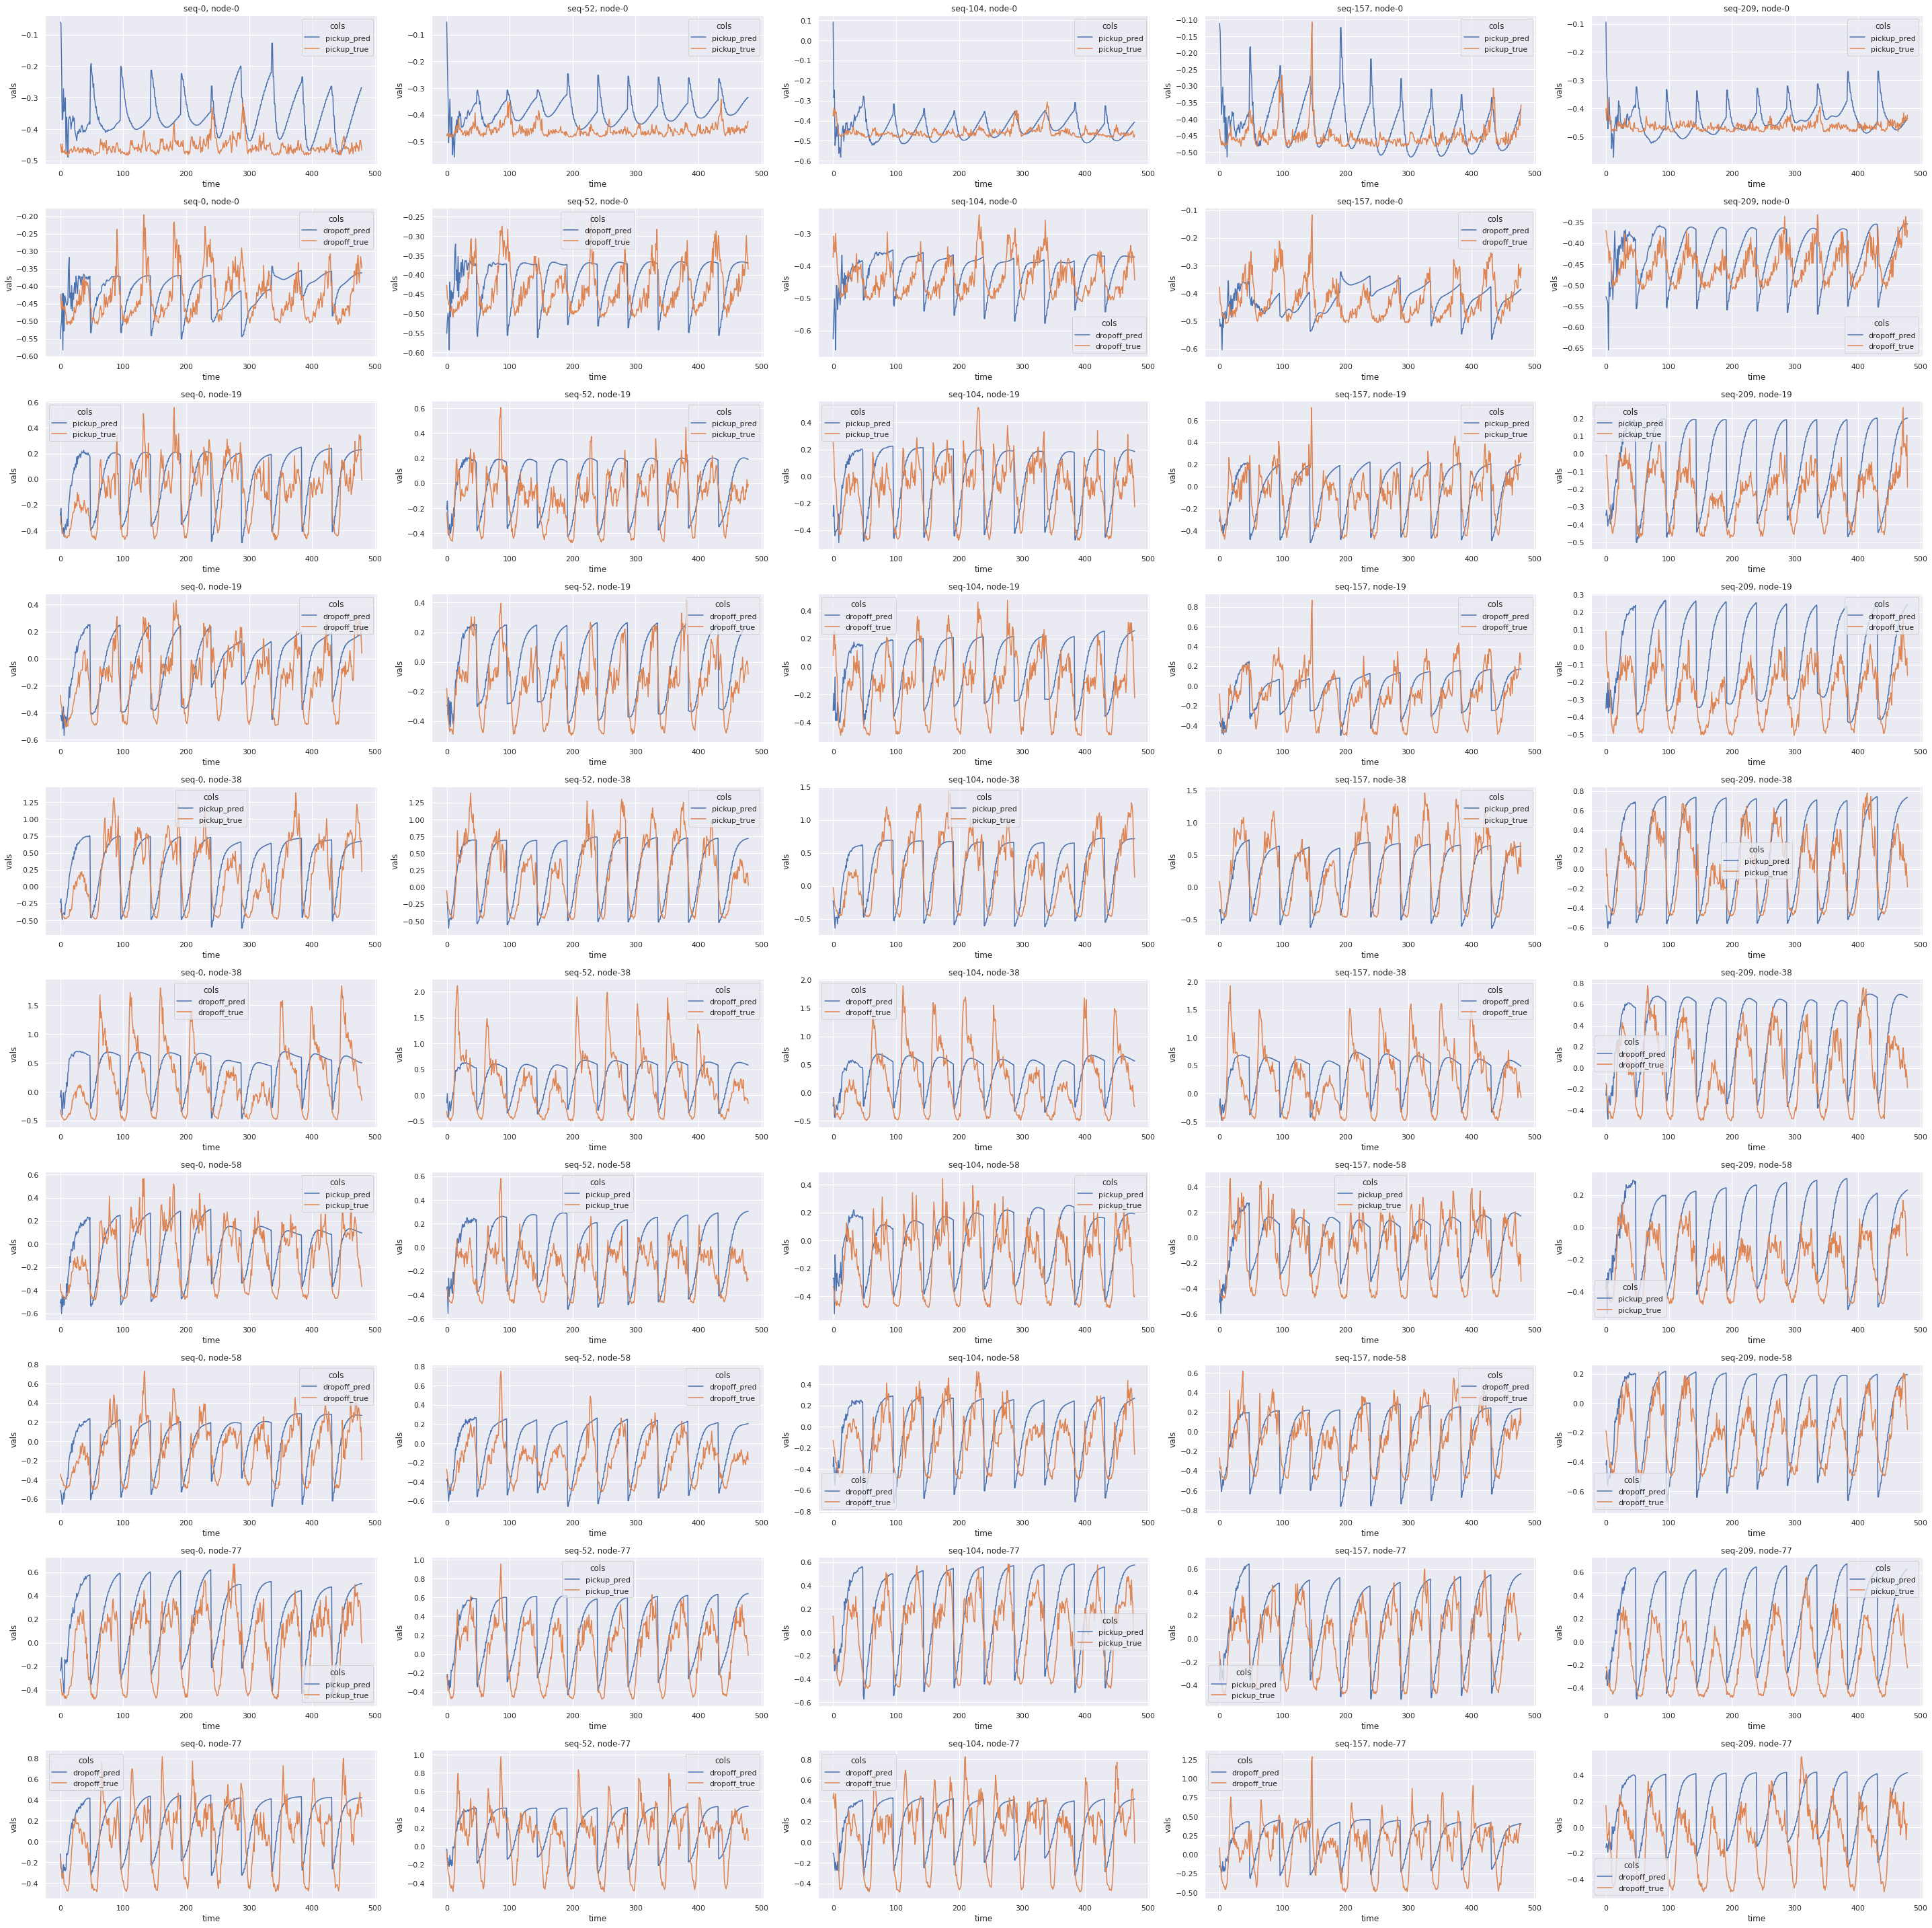

In [11]:
sample_ids = np.round(np.linspace(0, all_out.shape[0] - 1, num=5)).astype(int)
node_ids = np.round(np.linspace(0, all_out.shape[2] - 1, num=5)).astype(int)
feature_names = ['pickup', 'dropoff']

fig, axes = plt.subplots(len(node_ids) * len(feature_names), len(sample_ids), figsize=(len(sample_ids) * 8, len(node_ids) * len(feature_names) * 4))
for si, sample_id in enumerate(sample_ids):
    for ni, node_id in enumerate(node_ids):
        for fi, feature_name in enumerate(feature_names):
            out_data = all_out[sample_id, :, node_id, fi]
            state_data = all_states[sample_id, :, node_id, fi]
            ax = axes[ni * 2 + fi][si]
            pred_col = '{}_pred'.format(feature_name)
            true_col = '{}_true'.format(feature_name)
            diff_col = '{} - {}'.format(true_col, pred_col)
            data = pd.DataFrame({
                'time': np.arange(out_data.shape[0]),
                pred_col: out_data,
                true_col: state_data,
#                 diff_col: state_data - out_data
            })
            data = data.melt(id_vars=['time'], value_vars=[pred_col, true_col], var_name='cols', value_name='vals')
            sns.lineplot(data=data, x='time', y='vals', hue='cols', ax=ax)
            ax.set_title('seq-{}, node-{}'.format(sample_id, node_id))
fig.tight_layout()
plt.show()